<a href="https://colab.research.google.com/github/kahanikaar/GRIP/blob/main/Task4_GRIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import itertools
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.arima_model import ARIMA
import nltk
import re
from nltk.corpus import stopwords
from textblob import TextBlob
import math
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost 
import lightgbm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics 
from keras.models import Sequential
from keras.layers import Dense, LSTM

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kriti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kriti\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
# Dataframe for exploratory analysis
df=pd.read_csv('csv\^BSESN.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-10-16,38637.050781,38666.378906,38416.671875,38598.988281,38598.988281,27500.0
1,2019-10-17,38647.441406,39104.691406,38557.429688,39052.058594,39052.058594,47100.0
2,2019-10-18,39087.828125,39361.058594,38963.601563,39298.378906,39298.378906,42400.0
3,2019-10-22,39233.398438,39426.468750,38924.851563,38963.839844,38963.839844,54500.0
4,2019-10-23,39063.839844,39196.671875,38866.078125,39058.828125,39058.828125,41000.0


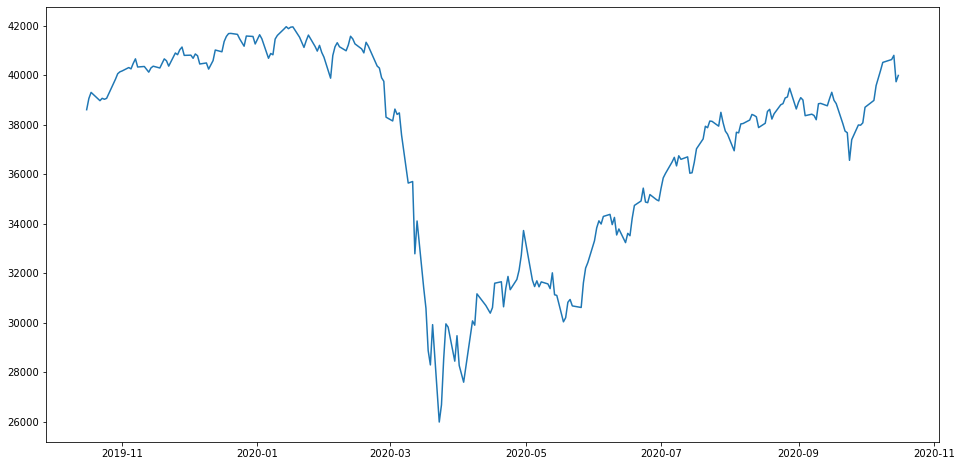

In [ ]:
# Extract date frame and plot closing stock price w.r.t time
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']
df.dropna(inplace=True)
#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')

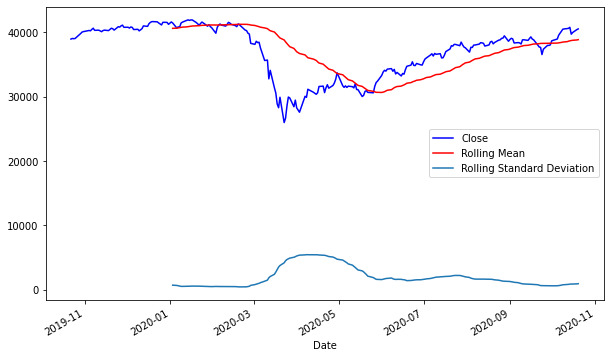

In [ ]:
#Plotting moving average
close = df['Close']
ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(10, 6))
df['Close'].plot(color = 'b', label = 'Close')
ma.plot(color = 'r', label = 'Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')
plt.legend()

Text(0.5, 1.0, 'Returns')

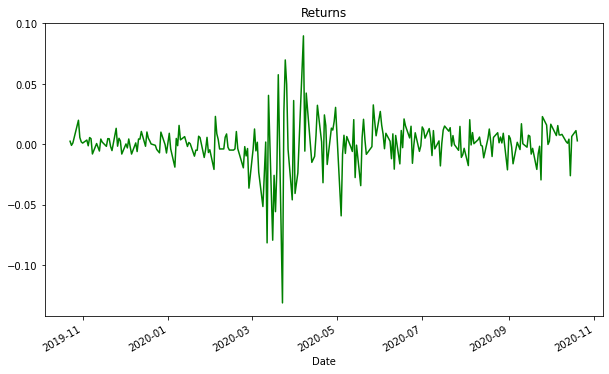

In [ ]:
#Plotting returns
returns = close / close.shift(1) - 1

plt.figure(figsize = (10,6))
returns.plot(label='Return', color = 'g')
plt.title("Returns")

In [ ]:
trainset = df[:1000]
testset = df[1000:]

In [ ]:
#defining stationery test function
def test_stationarity(timeseries):

 #Determing rolling statistics
 rolmean = timeseries.rolling(20).mean()
 rolstd = timeseries.rolling(20).std()

 #Plot rolling statistics:
 plt.figure(figsize = (10,8))
 plt.plot(timeseries, color = 'y', label = 'original')
 plt.plot(rolmean, color = 'r', label = 'rolling mean')
 plt.plot(rolstd, color = 'b', label = 'rolling std')
 plt.xlabel('Date')
 plt.legend()
 plt.title('Rolling Mean and Standard Deviation',  fontsize = 20)
 plt.show(block = False)
 
 print('Results of dickey fuller test')
 result = adfuller(timeseries, autolag = 'AIC')
 labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
 for value,label in zip(result, labels):
   print(label+' : '+str(value) )
 if result[1] <= 0.05:
   print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
 else:
   print("Weak evidence against null hypothesis, time series is non-stationary ")


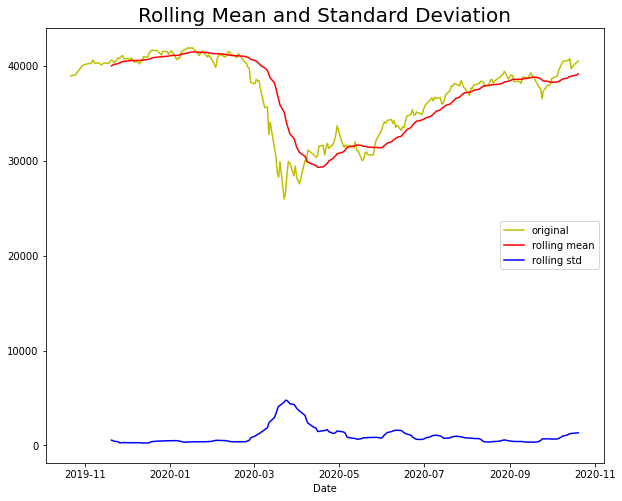

Results of dickey fuller test
ADF Test Statistic : -1.6355343224402958
p-value : 0.4645951790219187
#Lags Used : 7
Number of Observations Used : 240
Weak evidence against null hypothesis, time series is non-stationary 


In [ ]:
test_stationarity(trainset['Close'])

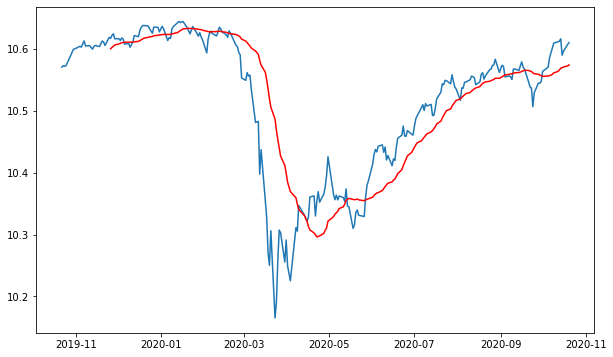

In [ ]:
train_log = np.log(trainset['Close']) 
test_log = np.log(testset['Close'])

mav = train_log.rolling(24).mean() 
plt.figure(figsize = (10,6))
plt.plot(train_log) 
plt.plot(mav, color = 'red')

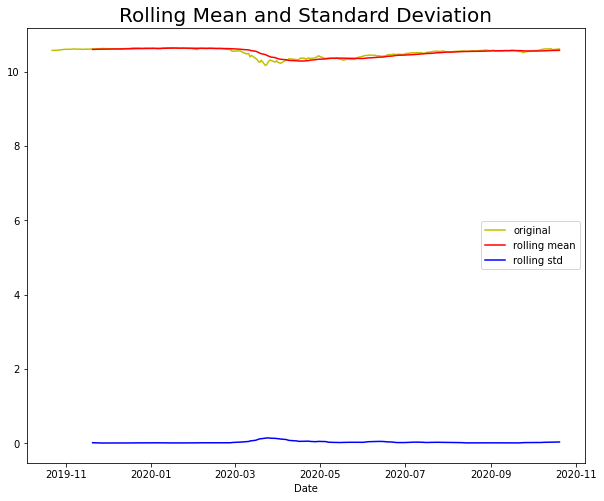

Results of dickey fuller test
ADF Test Statistic : -1.7342903810092332
p-value : 0.41353722635442286
#Lags Used : 7
Number of Observations Used : 240
Weak evidence against null hypothesis, time series is non-stationary 


In [ ]:
train_log.dropna(inplace = True)
test_log.dropna(inplace = True)

test_stationarity(train_log)

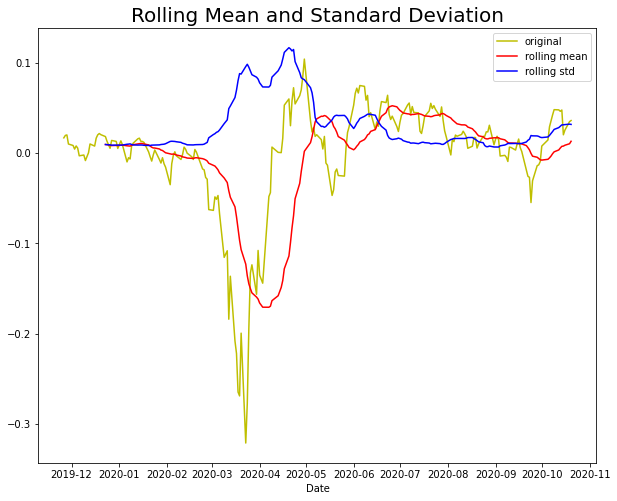

Results of dickey fuller test
ADF Test Statistic : -3.1307966052109024
p-value : 0.02435646872583167
#Lags Used : 7
Number of Observations Used : 217
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [ ]:
train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)
test_stationarity(train_log_diff)

In [ ]:
# fix random seed for reproducibility
np.random.seed(7)

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(df2, look_back=1):
	dataX, dataY = [], []
	for i in range(len(df2)-look_back-1):
		a = df2[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(df2[i + look_back, 0])
	return np.array(dataX), np.array(dataY)


In [ ]:
df2 = pd.read_csv('csv\^BSESN.csv', usecols=[5], engine='python')
df2.dropna(inplace=True)
df2 = df2.values
df2 = df2.astype('float32')

In [ ]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
df2 = scaler.fit_transform(df2)

# split into train and test sets
train_size = int(len(df2) * 0.67)
test_size = len(df2) - train_size
train, test = df2[0:train_size,:], df2[train_size:len(df2),:]

In [ ]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(7, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
162/162 - 0s - loss: 0.3630
Epoch 2/100
162/162 - 0s - loss: 0.0353
Epoch 3/100
162/162 - 0s - loss: 0.0214
Epoch 4/100
162/162 - 0s - loss: 0.0126
Epoch 5/100
162/162 - 0s - loss: 0.0070
Epoch 6/100
162/162 - 0s - loss: 0.0044
Epoch 7/100
162/162 - 0s - loss: 0.0035
Epoch 8/100
162/162 - 0s - loss: 0.0032
Epoch 9/100
162/162 - 0s - loss: 0.0032
Epoch 10/100
162/162 - 0s - loss: 0.0031
Epoch 11/100
162/162 - 0s - loss: 0.0033
Epoch 12/100
162/162 - 0s - loss: 0.0032
Epoch 13/100
162/162 - 0s - loss: 0.0032
Epoch 14/100
162/162 - 0s - loss: 0.0032
Epoch 15/100
162/162 - 0s - loss: 0.0032
Epoch 16/100
162/162 - 0s - loss: 0.0032
Epoch 17/100
162/162 - 0s - loss: 0.0032
Epoch 18/100
162/162 - 0s - loss: 0.0033
Epoch 19/100
162/162 - 0s - loss: 0.0031
Epoch 20/100
162/162 - 0s - loss: 0.0031
Epoch 21/100
162/162 - 0s - loss: 0.0031
Epoch 22/100
162/162 - 0s - loss: 0.0031
Epoch 23/100
162/162 - 0s - loss: 0.0032
Epoch 24/100
162/162 - 0s - loss: 0.0031
Epoch 25/100
162/162 - 0s

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

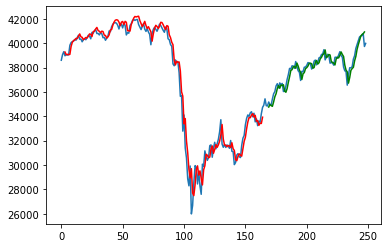

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df2)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df2)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df2)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df2))
plt.plot(trainPredictPlot,color='red')
plt.plot(testPredictPlot,color='green')
plt.show()

In [ ]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print("Root mean square error = ",trainScore," RMSE")
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print("Root mean square error = ",testScore," RMSE")



Root mean square error =  743.2663269537377  RMSE
Root mean square error =  436.67106263118023  RMSE


In [ ]:
#Text Analysis

columns = ['Date','Category','News']
news = pd.read_csv('csv\india-news-headlines.csv', names = columns)
news

,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010101,sports.wwe,win over cena satisfying but defeating underta...
2,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
3,20010102,unknown,Fissures in Hurriyat over Pak visit
4,20010102,unknown,America's unwanted heading for India?
...,...,...,...
3297168,20200630,gadgets-news,why tiktok removed 1 65 crore videos in india
3297169,20200630,entertainment.hindi.bollywood,apurva asrani calls alia bhatts mother soni ra...
3297170,20200630,entertainment.hindi.bollywood,kangana ranaut gets a doll version of herself ...
3297171,20200630,entertainment.hindi.bollywood,meezaan jaffrey reminisces his childhood days ...


In [ ]:
news.drop(0, inplace=True)
news.drop('Category', axis = 1, inplace=True)
news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3297172 entries, 1 to 3297172
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Date    object
 1   News    object
dtypes: object(2)
memory usage: 75.5+ MB


In [ ]:
# Restructuring the date format
news['Date'] = pd.to_datetime(news['Date'],format= '%Y %m %d')
news

,Date,News
1,2001-01-01 00:00:00.000000000,win over cena satisfying but defeating underta...
2,2001-01-02 00:00:00.000000000,Status quo will not be disturbed at Ayodhya; s...
3,2001-01-02 00:00:00.000000000,Fissures in Hurriyat over Pak visit
4,2001-01-02 00:00:00.000000000,America's unwanted heading for India?
5,2001-01-02 00:00:00.000000000,For bigwigs; it is destination Goa
...,...,...
3297168,1970-01-01 00:00:00.020200630,why tiktok removed 1 65 crore videos in india
3297169,1970-01-01 00:00:00.020200630,apurva asrani calls alia bhatts mother soni ra...
3297170,1970-01-01 00:00:00.020200630,kangana ranaut gets a doll version of herself ...
3297171,1970-01-01 00:00:00.020200630,meezaan jaffrey reminisces his childhood days ...


In [ ]:
#Grouping the headlines for each day
news['News'] = news.groupby(['Date']).transform(lambda x : ' '.join(x)) 
news = news.drop_duplicates() 
news.reset_index(inplace = True, drop = True)
news

,Date,News
0,2001-01-01 00:00:00.000000000,win over cena satisfying but defeating underta...
1,2001-01-02 00:00:00.000000000,Status quo will not be disturbed at Ayodhya; s...
2,2001-01-03 00:00:00.000000000,Powerless north India gropes in the dark Think...
3,2001-01-04 00:00:00.000000000,The string that pulled Stephen Hawking to Indi...
4,2001-01-05 00:00:00.000000000,Light combat craft takes India into club class...
...,...,...
7076,1970-01-01 00:00:00.020200626,Containment zone residents slam high prices ch...
7077,1970-01-01 00:00:00.020200627,like me i wont let you have a toxic relationsh...
7078,1970-01-01 00:00:00.020200628,Atanu Ghosh plans to rewrite old scripts to ma...
7079,1970-01-01 00:00:00.020200629,6 hot and stylish bikini looks of Katrina Kaif...


In [ ]:
news['News']

0       win over cena satisfying but defeating underta...
1       Status quo will not be disturbed at Ayodhya; s...
2       Powerless north India gropes in the dark Think...
3       The string that pulled Stephen Hawking to Indi...
4       Light combat craft takes India into club class...
                              ...                        
7076    Containment zone residents slam high prices ch...
7077    like me i wont let you have a toxic relationsh...
7078    Atanu Ghosh plans to rewrite old scripts to ma...
7079    6 hot and stylish bikini looks of Katrina Kaif...
7080    Detective Byomkesh Bakshy! Edge of Tomorrow Fi...
Name: News, Length: 7081, dtype: object

In [ ]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [ ]:
#Adding subjectivity and polarity columns
news['Subjectivity'] = news['News'].apply(getSubjectivity)
news['Polarity'] = news['News'].apply(getPolarity)
news

,Date,News,Subjectivity,Polarity
0,2001-01-01 00:00:00.000000000,win over cena satisfying but defeating underta...,0.633333,0.433333
1,2001-01-02 00:00:00.000000000,Status quo will not be disturbed at Ayodhya; s...,0.282333,0.151333
2,2001-01-03 00:00:00.000000000,Powerless north India gropes in the dark Think...,0.407692,0.088462
3,2001-01-04 00:00:00.000000000,The string that pulled Stephen Hawking to Indi...,0.446847,0.087961
4,2001-01-05 00:00:00.000000000,Light combat craft takes India into club class...,0.476612,0.262024
...,...,...,...,...
7076,1970-01-01 00:00:00.020200626,Containment zone residents slam high prices ch...,0.381841,0.068333
7077,1970-01-01 00:00:00.020200627,like me i wont let you have a toxic relationsh...,0.398808,0.079290
7078,1970-01-01 00:00:00.020200628,Atanu Ghosh plans to rewrite old scripts to ma...,0.402636,0.057636
7079,1970-01-01 00:00:00.020200629,6 hot and stylish bikini looks of Katrina Kaif...,0.396828,0.061956


<AxesSubplot:>

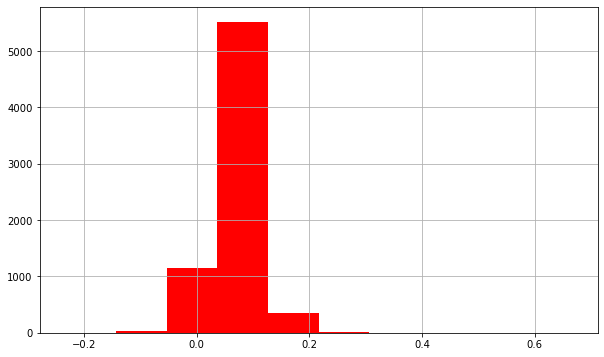

In [ ]:
plt.figure(figsize = (10,6))
news['Polarity'].hist(color = 'red')

<AxesSubplot:>

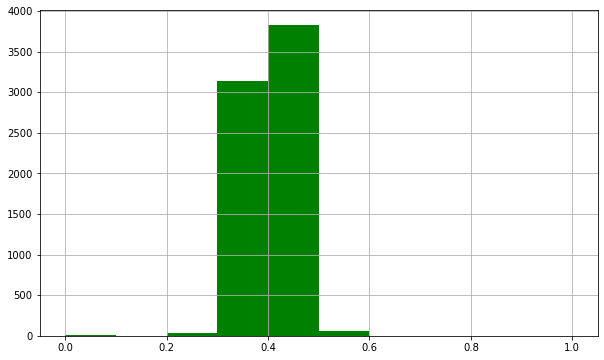

In [ ]:
plt.figure(figsize = (10,6))
news['Subjectivity'].hist(color = 'green')

In [ ]:
#Adding sentiment score to news
sia = SentimentIntensityAnalyzer()

news['Compound'] = [sia.polarity_scores(v)['compound'] for v in news['News']]
news['Negative'] = [sia.polarity_scores(v)['neg'] for v in news['News']]
news['Neutral'] = [sia.polarity_scores(v)['neu'] for v in news['News']]
news['Positive'] = [sia.polarity_scores(v)['pos'] for v in news['News']]
news

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-01 00:00:00.000000000,win over cena satisfying but defeating underta...,0.633333,0.433333,-0.0000,0.230,0.473,0.297
1,2001-01-02 00:00:00.000000000,Status quo will not be disturbed at Ayodhya; s...,0.282333,0.151333,-0.9811,0.122,0.807,0.071
2,2001-01-03 00:00:00.000000000,Powerless north India gropes in the dark Think...,0.407692,0.088462,-0.2640,0.122,0.766,0.111
3,2001-01-04 00:00:00.000000000,The string that pulled Stephen Hawking to Indi...,0.446847,0.087961,0.8738,0.100,0.797,0.103
4,2001-01-05 00:00:00.000000000,Light combat craft takes India into club class...,0.476612,0.262024,0.9769,0.124,0.719,0.157
...,...,...,...,...,...,...,...,...
7076,1970-01-01 00:00:00.020200626,Containment zone residents slam high prices ch...,0.381841,0.068333,-0.9999,0.163,0.748,0.089
7077,1970-01-01 00:00:00.020200627,like me i wont let you have a toxic relationsh...,0.398808,0.079290,-0.9999,0.159,0.749,0.092
7078,1970-01-01 00:00:00.020200628,Atanu Ghosh plans to rewrite old scripts to ma...,0.402636,0.057636,-0.9999,0.151,0.774,0.075
7079,1970-01-01 00:00:00.020200629,6 hot and stylish bikini looks of Katrina Kaif...,0.396828,0.061956,-0.9999,0.144,0.770,0.086


In [ ]:
merge = news
merge

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-01 00:00:00.000000000,win over cena satisfying but defeating underta...,0.633333,0.433333,-0.0000,0.230,0.473,0.297
1,2001-01-02 00:00:00.000000000,Status quo will not be disturbed at Ayodhya; s...,0.282333,0.151333,-0.9811,0.122,0.807,0.071
2,2001-01-03 00:00:00.000000000,Powerless north India gropes in the dark Think...,0.407692,0.088462,-0.2640,0.122,0.766,0.111
3,2001-01-04 00:00:00.000000000,The string that pulled Stephen Hawking to Indi...,0.446847,0.087961,0.8738,0.100,0.797,0.103
4,2001-01-05 00:00:00.000000000,Light combat craft takes India into club class...,0.476612,0.262024,0.9769,0.124,0.719,0.157
...,...,...,...,...,...,...,...,...
7076,1970-01-01 00:00:00.020200626,Containment zone residents slam high prices ch...,0.381841,0.068333,-0.9999,0.163,0.748,0.089
7077,1970-01-01 00:00:00.020200627,like me i wont let you have a toxic relationsh...,0.398808,0.079290,-0.9999,0.159,0.749,0.092
7078,1970-01-01 00:00:00.020200628,Atanu Ghosh plans to rewrite old scripts to ma...,0.402636,0.057636,-0.9999,0.151,0.774,0.075
7079,1970-01-01 00:00:00.020200629,6 hot and stylish bikini looks of Katrina Kaif...,0.396828,0.061956,-0.9999,0.144,0.770,0.086


In [ ]:
dff = merge[['Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral' ,'Positive']]
dff

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.633333,0.433333,-0.0000,0.230,0.473,0.297
1,0.282333,0.151333,-0.9811,0.122,0.807,0.071
2,0.407692,0.088462,-0.2640,0.122,0.766,0.111
3,0.446847,0.087961,0.8738,0.100,0.797,0.103
4,0.476612,0.262024,0.9769,0.124,0.719,0.157
...,...,...,...,...,...,...
7076,0.381841,0.068333,-0.9999,0.163,0.748,0.089
7077,0.398808,0.079290,-0.9999,0.159,0.749,0.092
7078,0.402636,0.057636,-0.9999,0.151,0.774,0.075
7079,0.396828,0.061956,-0.9999,0.144,0.770,0.086


In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
new_df = pd.DataFrame(sc.fit_transform(dff))
new_df.columns = dff.columns
new_df.index = dff.index
new_df.head()

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.633333,0.740741,0.50000,0.518018,0.473,0.488487
1,0.282333,0.427407,0.00945,0.274775,0.807,0.116776
2,0.407692,0.357550,0.36800,0.274775,0.766,0.182566
3,0.446847,0.356994,0.93690,0.225225,0.797,0.169408
4,0.476612,0.550397,0.98845,0.279279,0.719,0.258224


In [ ]:
X = new_df[0:249]
y =df['Close']

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
x_train.shape

(199, 6)

In [ ]:
x_train[:10]

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
108,0.405833,0.540833,0.02510,0.373874,0.734,0.164474
18,0.375486,0.391781,0.09990,0.364865,0.709,0.212171
205,0.433601,0.297440,0.00385,0.272523,0.772,0.175987
15,0.383333,0.339506,0.97700,0.171171,0.780,0.235197
71,0.344118,0.308279,0.00900,0.527027,0.607,0.259868
7,0.414653,0.237911,0.01105,0.272523,0.812,0.108553
228,0.358700,0.246596,0.00035,0.362613,0.772,0.111842
180,0.419285,0.357075,0.00065,0.270270,0.805,0.123355
146,0.750000,0.814815,0.83525,0.121622,0.765,0.297697
160,0.338659,0.281909,0.00045,0.362613,0.772,0.110197


In [ ]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
prediction=rf.predict(x_test)

In [ ]:
print(prediction[:10])
print(y_test[:10])
print("Root mean square error = ",math.sqrt(mean_squared_error(prediction,y_test))," RMSE")

[35598.12658208 37239.59140617 39023.23419916 36323.50489589
 36590.70015856 39671.98542975 38501.40583986 35799.45554693
 38753.79585939 38402.70117203]
Date
2020-10-16    39982.980469
2020-06-25    34842.101563
2020-02-06    41306.031250
2020-06-01    33303.519531
2020-05-22    30672.589844
2020-02-03    39872.308594
2019-12-23    41642.660156
2020-06-12    33780.890625
2020-09-03    38990.941406
2020-08-27    39113.468750
Name: Close, dtype: float64
Root mean square error =  3960.4218896724724  RMSE


In [ ]:
adb = AdaBoostRegressor()
adb.fit(x_train, y_train)
predictions = adb.predict(x_test)

In [ ]:
print("Root mean square error = ",math.sqrt(mean_squared_error(predictions, y_test))," RMSE")

Root mean square error =  4074.461310273298  RMSE
